In [1]:
# Parkinsonics Other Measures Data Analysis - VRQOL
# Kevin Li
# 04.28.2020

import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as smt
import statsmodels.api as sm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
import missingno as msno

# Exploratory Analysis of VRQOL All Visits Data

Load VRQOL data and ID sheet, clean as necessary

In [2]:
# Load VRQOL scores
vqdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures\VRQOL_all_visits_08262016.xlsx')

# Clean up column names: remove "vrqol_" from beginning
newcols=['ID']
for i in vqdf.columns[1:]:
    newcols.append(i[6:])
vqdf.columns=newcols
    
# Load randomization patient ID list
IDdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Parkinsonics_RandID_ List_DID.xlsx')
IDdf=IDdf[:-5]
S_group=IDdf.loc[IDdf['First Intervention']=='S']
D_group=IDdf.loc[IDdf['First Intervention']=='D']
M_gen=IDdf.loc[IDdf['Gender']=='M']
F_gen=IDdf.loc[IDdf['Gender']=='F']

# Clean datatypes
IDdf['ID']=IDdf['ID'].astype(float)
IDsort=IDdf['ID'].sort_values().reset_index()['ID']

# Concat ID data to the main dataframe
vqdf=pd.merge(vqdf, IDdf, on='ID')

Find percentage of missing data

In [3]:
miss_count=0
tot_count=0
for col in range(67):
    for row in range(26):
        tot_count+=1
        if np.isnan(vqdf.iloc[row, col]):
            miss_count+=1
                
miss_ratio=miss_count/tot_count
miss_ratio

0.027554535017221583

Separate items of VRQOL data, all timepoints in one df

In [4]:
i1=['ID', 'item1_BL', 'item1_V01', 'item1_V02', 'item1_V03', 'item1_V04', 'item1_V05']
i2=['ID', 'item2_BL', 'item2_V01', 'item2_V02', 'item2_V03', 'item2_V04', 'item2_V05']
i3=['ID', 'item3_BL', 'item3_V01', 'item3_V02', 'item3_V03', 'item3_V04', 'item3_V05']
i4=['ID', 'item4_BL', 'item4_V01', 'item4_V02', 'item4_V03', 'item4_V04', 'item4_V05']
i5=['ID', 'item5_BL', 'item5_V01', 'item5_V02', 'item5_V03', 'item5_V04', 'item5_V05']
i6=['ID', 'item6_BL', 'item6_V01', 'item6_V02', 'item6_V03', 'item6_V04', 'item6_V05']
i7=['ID', 'item7_BL', 'item7_V01', 'item7_V02', 'item7_V03', 'item7_V04', 'item7_V05']
i8=['ID', 'item8_BL', 'item8_V01', 'item8_V02', 'item8_V03', 'item8_V04', 'item8_V05']
i9=['ID', 'item9_BL', 'item9_V01', 'item9_V02', 'item9_V03', 'item9_V04', 'item9_V05']
i10=['ID', 'item10_BL', 'item10_V01', 'item10_V02', 'item10_V03', 'item10_V04', 'item10_V05']
tot=['ID', 'BL', 'V1', 'V2', 'V3', 'V4', 'V5']

items=[i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, tot]

Implement LOCF for missing data points

In [5]:
# Step 1: Check BL for each subscore, drop patients with nan values for that subscore & Total
miss_ID=[0]
miss_item=['blank']
miss_group=[0]
copydf=vqdf.copy()
for i in range(11):
    itemtps=items[i]
    for ID in range(26):
        if np.isnan(copydf.iloc[ID, i+1]):
            if miss_item[0]=='blank':
            # If the missing items list is unpopulated
                miss_item[0]=i
                miss_ID[0]=[vqdf['ID'][ID]]
                miss_group[0]=[vqdf['First Intervention'][ID]]
            else:
            # The missing items list has elements
                count1=0
                for m_items in miss_item:
                    if m_items==i:
                        count2=0
                        for m_ID in miss_ID[-1]:
                            if m_ID==vqdf['ID'][ID]:
                                count2+=1
                        if count2==0:
                            miss_ID[-1].append(vqdf['ID'][ID])
                            miss_group[-1].append(vqdf['First Intervention'][ID])
                        count1+=1
                if count1==0:
                    miss_item.append(i)
                    miss_ID.append([vqdf['ID'][ID]])
                    miss_group.append([vqdf['First Intervention'][ID]])
            for tp in range(1,7):
                copydf.loc[ID, itemtps[tp]]=float('nan')
                copydf.loc[ID, tot[tp]]=float('nan')
                
            
# Step 2: Check V1-V5 for each subscore, carry forward last observation in place of missing data
for i in range(11):
    tempdf=copydf[items[i]]
    # Iterate through each entry of each subscore df, search for nan values
    for tp in range(2,7):
        for ID in range(26):
            # If nan, set equal to value at previous tp
            if np.isnan(tempdf.iloc[ID, tp]):
                if miss_item[0]=='blank':
            # If the missing items list is unpopulated
                    miss_item[0]=i
                    miss_ID[0]=[vqdf['ID'][ID]]
                    miss_group[0]=[vqdf['First Intervention'][ID]]
                else:
            # The missing items list has elements
                    count1=0
                    for j in range(len(miss_item)):
                        if miss_item[j]==i:
                            count2=0
                            for m_ID in miss_ID[j]:
                                if m_ID==vqdf['ID'][ID]:
                                    count2+=1
                            if count2==0:
                                miss_ID[j].append(vqdf['ID'][ID])
                                miss_group[j].append(vqdf['First Intervention'][ID])
                            count1+=1
                    if count1==0:
                        miss_item.append(i)
                        miss_ID.append([vqdf['ID'][ID]])
                        miss_group.append([vqdf['First Intervention'][ID]])
                tempdf.iloc[ID, tp]=tempdf.iloc[ID, tp-1]
    if i==0:
        locfdf=tempdf
    if i!=0:    
        locfdf=pd.concat([locfdf, tempdf.iloc[:, 1:]], axis=1, sort=False)
        
locfdf=pd.merge(locfdf, IDdf, on='ID')

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Stratify VRQOL by group

In [6]:
# LOCF data:
S_vq_locf=locfdf.loc[locfdf['First Intervention']=='S']
D_vq_locf=locfdf.loc[locfdf['First Intervention']=='D']

# Original data:
S_vq_orig=vqdf.loc[vqdf['First Intervention']=='S']
D_vq_orig=vqdf.loc[vqdf['First Intervention']=='D']

# Missing data visualisation

Utilize missingno to create nullity matrix and nullity correlation heatmap between all vars

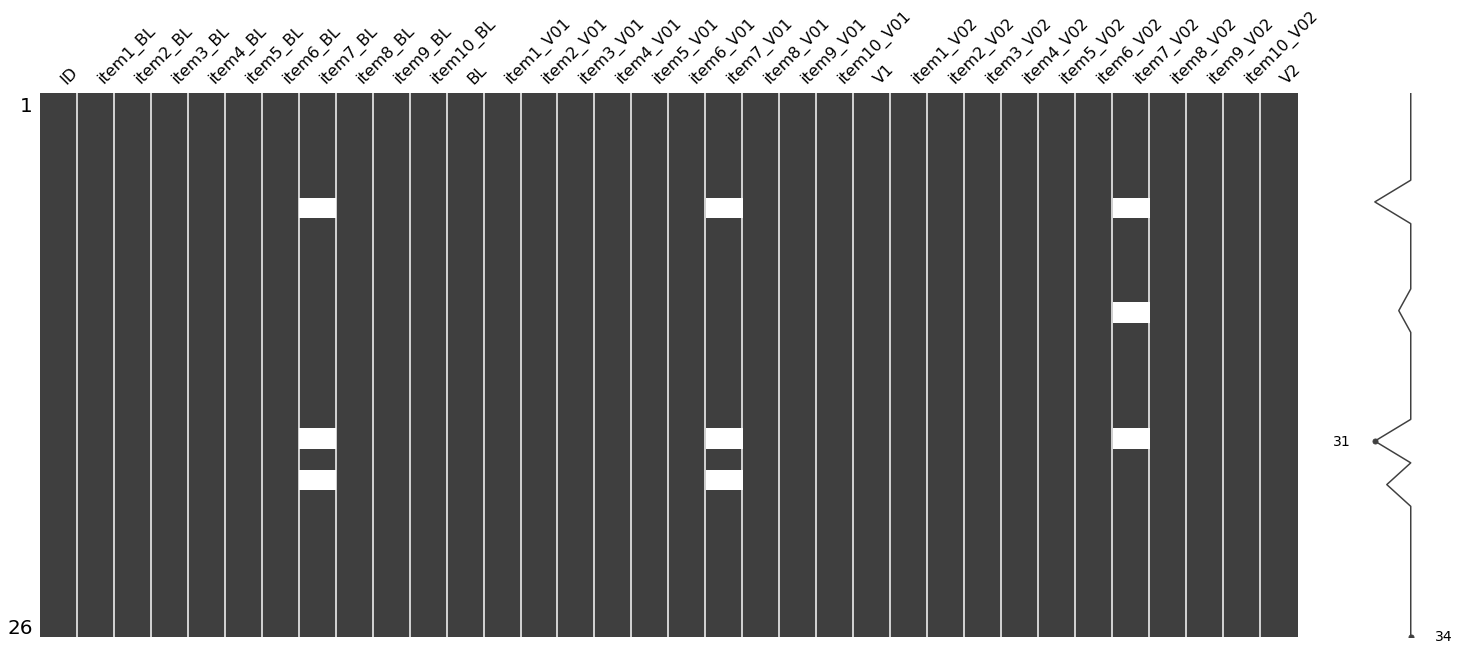

In [22]:
msno.matrix(vqdf.loc[:, :'V2'])

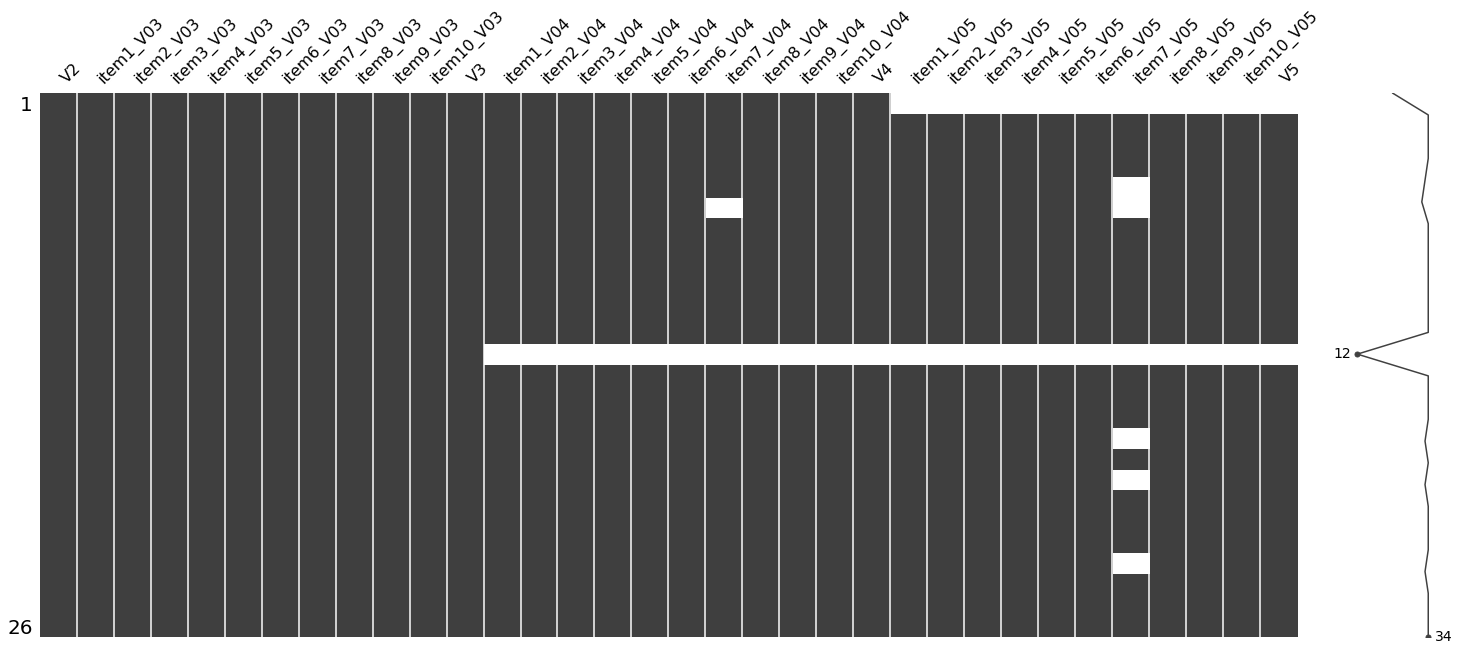

In [24]:
msno.matrix(vqdf.loc[:, 'V2':'V5'])

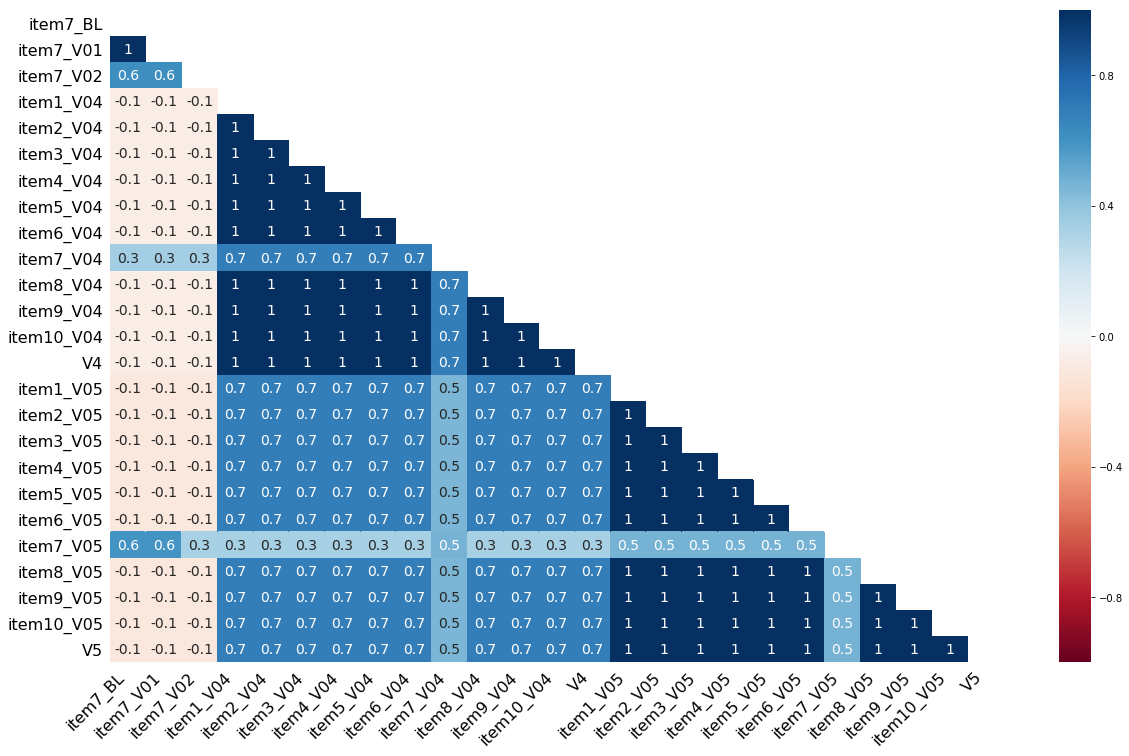

In [13]:
msno.heatmap(vqdf.iloc[:, ])

# All Participants/Groupwise Plots - Spaghetti

Start-end paired T-tests

In [10]:
# One p value for each item
# Create 2 initial dfs to append to within each loop

# LOCF data:
S_se_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])
D_se_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(11):
    if i!=10:
        itemnum=str(count)
    elif i==10:
        itemnum='Tot'
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_vq_locf[items[i]].iloc[:, np.r_[1,6]].drop([8])
    D_se=D_vq_locf[items[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        tempvq=sedflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempvq.iloc[:, 0], tempvq.iloc[:, 1], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempvq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempvq.iloc[:, 1])

        if j==0:            
            S_se_locf=pd.concat([S_se_locf, tempdf], sort=False)
        elif j==1:
            D_se_locf=pd.concat([D_se_locf, tempdf], sort=False)
    count+=1
    
    
# Original data:
S_se_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])
D_se_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(11):
    if i!=10:
        itemnum=str(count)
    elif i==10:
        itemnum='Tot'
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_vq_orig[items[i]].iloc[:, np.r_[1,6]].drop([8])
    D_se=D_vq_orig[items[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        tempvq=sedflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempvq.iloc[:, 0], tempvq.iloc[:, 1], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempvq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempvq.iloc[:, 1])

        if j==0:            
            S_se_orig=pd.concat([S_se_orig, tempdf], sort=False)
        elif j==1:
            D_se_orig=pd.concat([D_se_orig, tempdf], sort=False)
    count+=1


Sub 0.05 pval for S_se_locf, item 10. Correction for multiple comparisons with SH yields failure to reject H0, so we report without correction.

No change after omission of patient ID 35303

In [59]:
S_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\VRQOL\LOCF\VRQOL_TTest_StartEnd_S_Orig.xlsx')
D_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\VRQOL\LOCF\VRQOL_TTest_StartEnd_D_Orig.xlsx')

S_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\VRQOL\Original\VRQOL_TTest_StartEnd_S_Orig.xlsx')
D_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\VRQOL\Original\VRQOL_TTest_StartEnd_D_Orig.xlsx')

Plots: S Group - Singing First

LOCF Data Plots


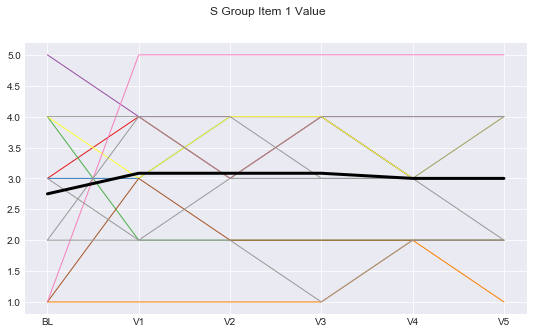

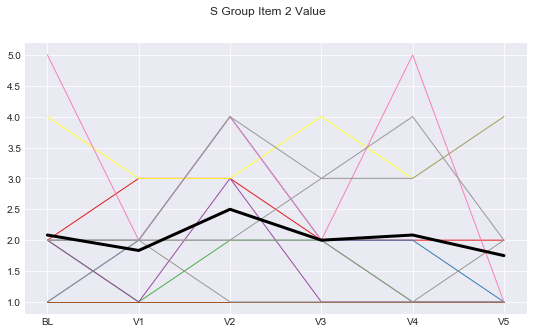

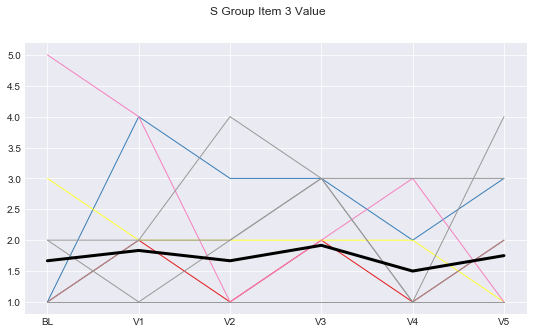

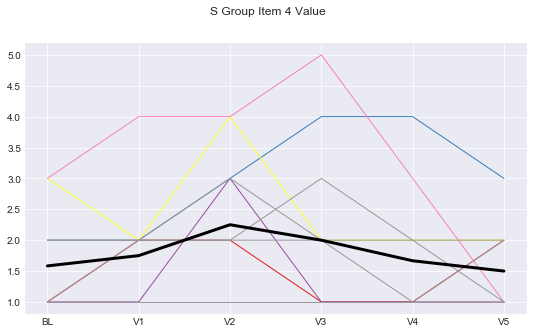

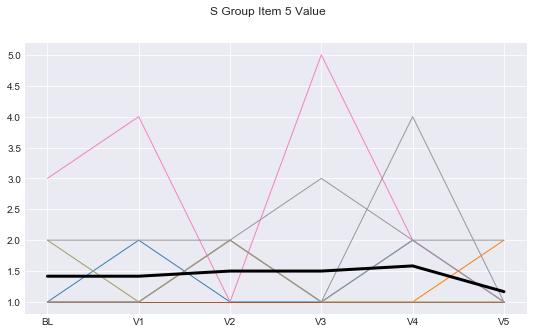

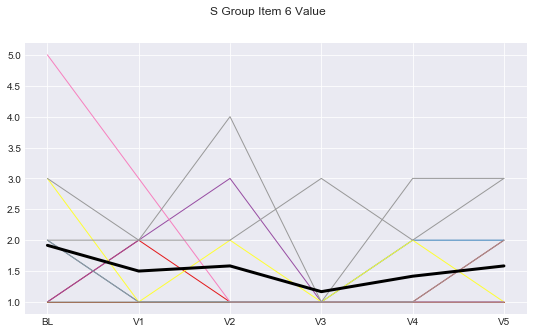

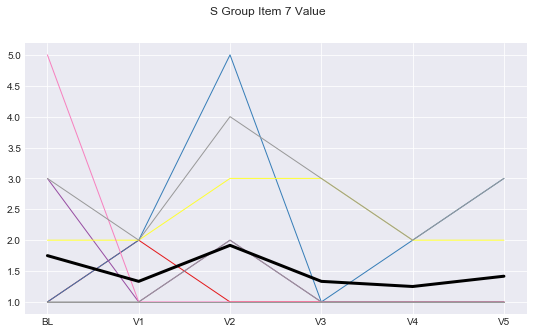

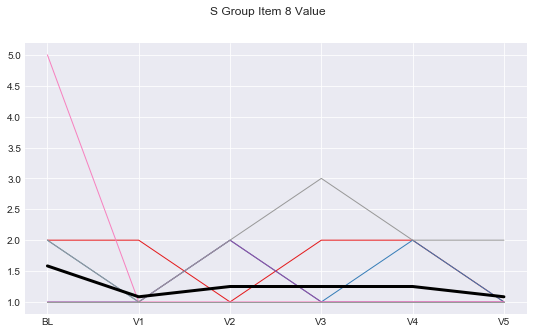

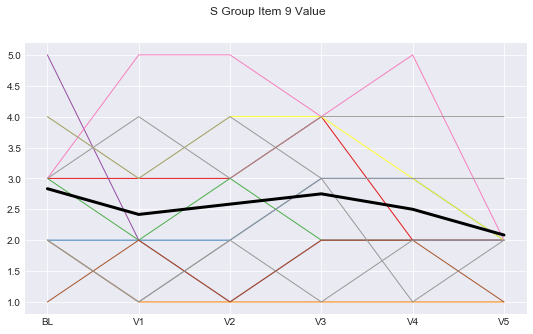

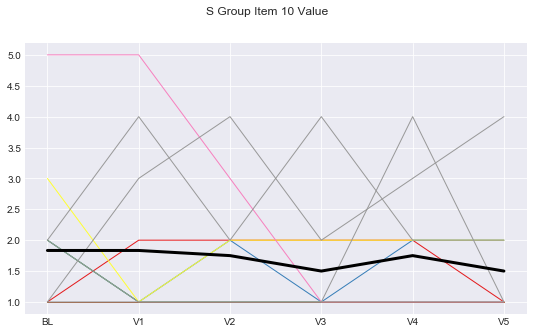

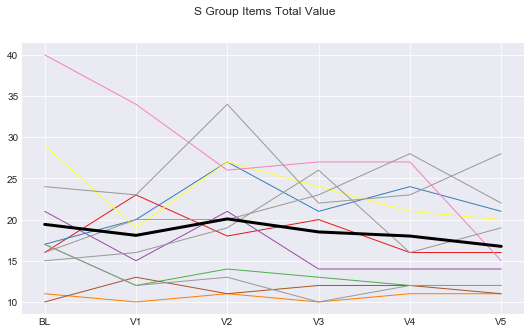

Original Data Plots


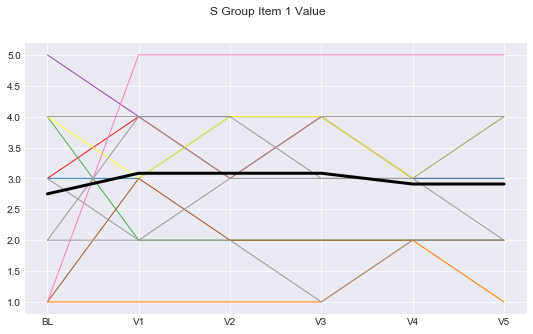

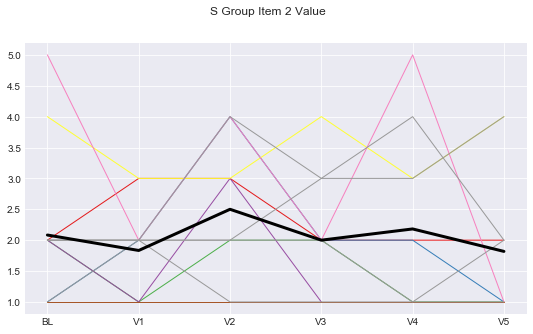

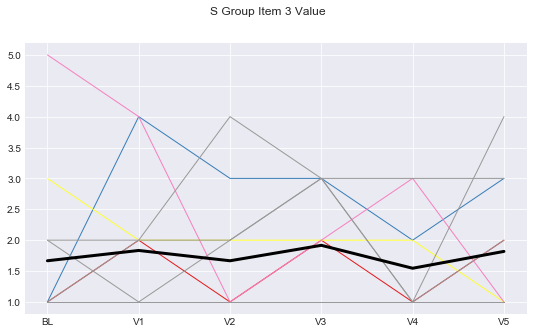

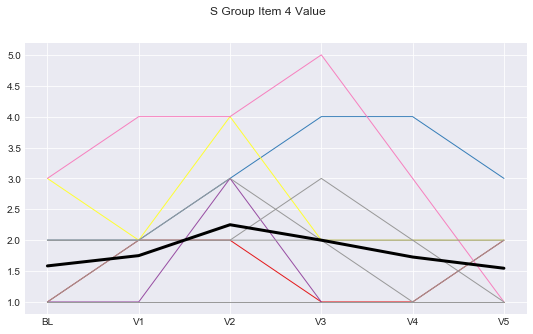

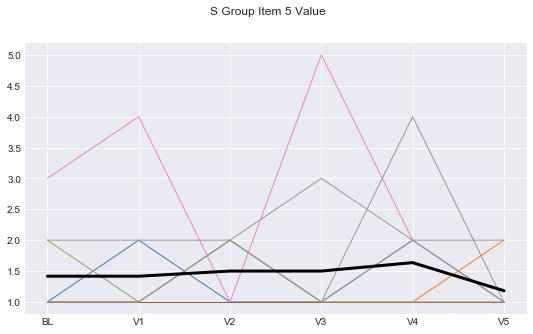

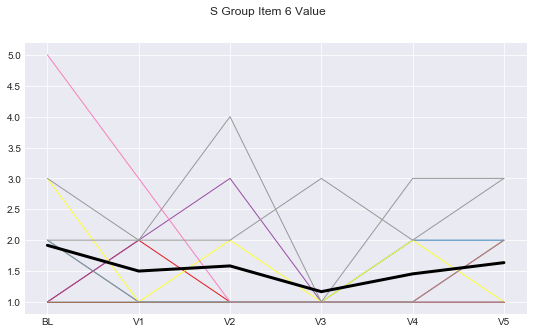

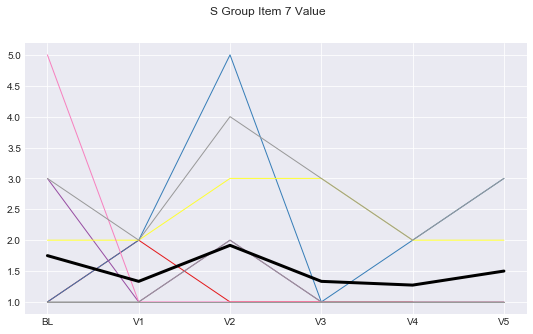

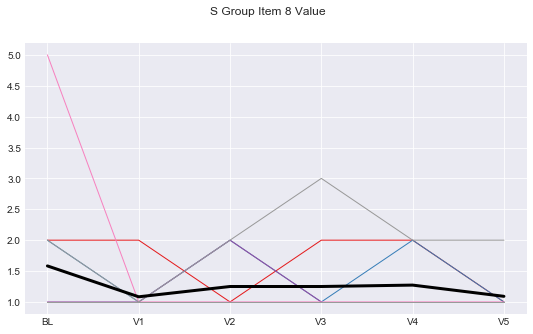

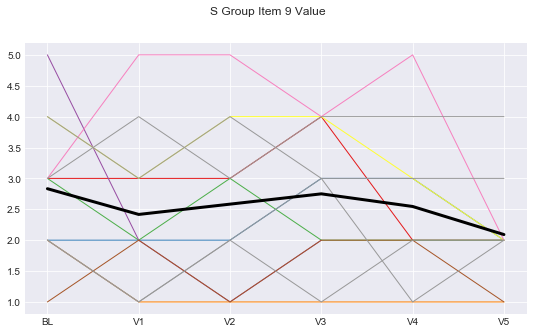

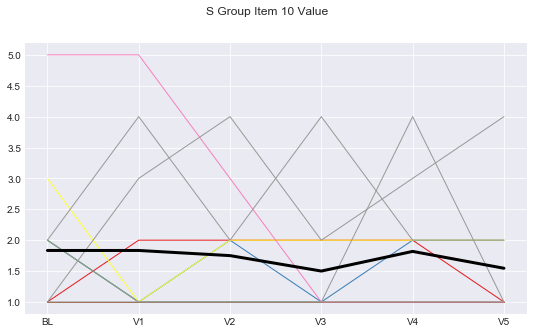

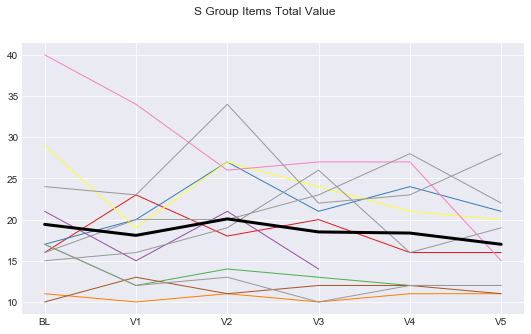

In [30]:
# Need to loop through the different subscores for each S and D
timepoints=['BL', 'V1', 'V2', 'V3', 'V4', 'V5']

# LOCF data
# Need to drop 35303 b/c outlier at V4
print('LOCF Data Plots')

count=1
for i in range(11):
    if i!=10:
        itemnum=str(count)
    S_item=S_vq_locf[items[i]].drop([8])
    # Add a row for the mean of all patients at each tp
    S_item=S_item.append(S_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        S_plot=S_item.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_item.iloc[12][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=10:
        plt.suptitle('S Group Item '+itemnum+' Value')
    elif i==10:
        plt.suptitle('S Group Items Total Value')
    plt.show()
    count+=1
    
# Original data
# Need to drop 35303 b/c outlier at V4
print('Original Data Plots')

count=1
for i in range(11):
    if i!=10:
        itemnum=str(count)
    S_item=S_vq_orig[items[i]].drop([8])
    # Add a row for the mean of all patients at each tp
    S_item=S_item.append(S_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        S_plot=S_item.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_item.iloc[12][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=10:
        plt.suptitle('S Group Item '+itemnum+' Value')
    elif i==10:
        plt.suptitle('S Group Items Total Value')
    plt.show()
    count+=1

Plot: D Group - Discussion First

LOCF Data Plots


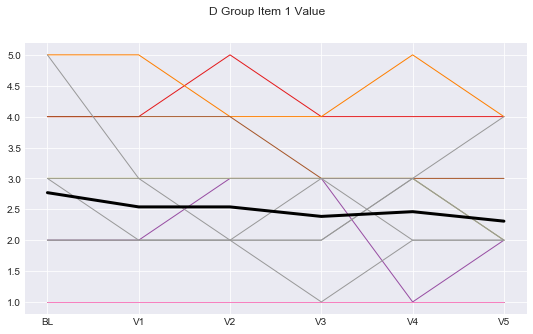

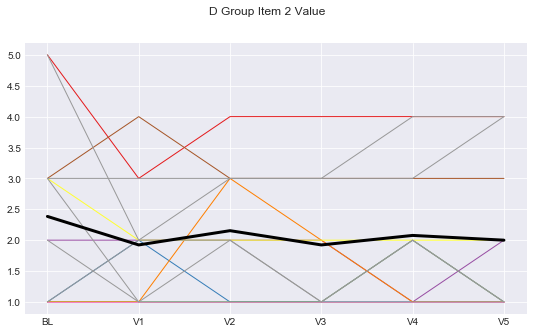

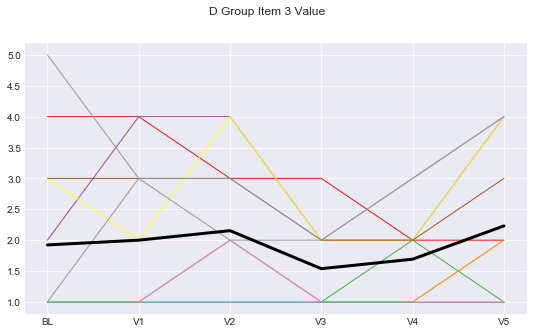

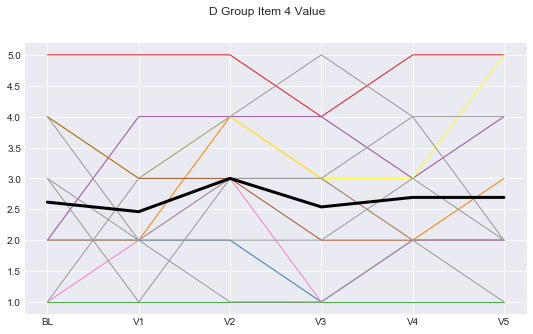

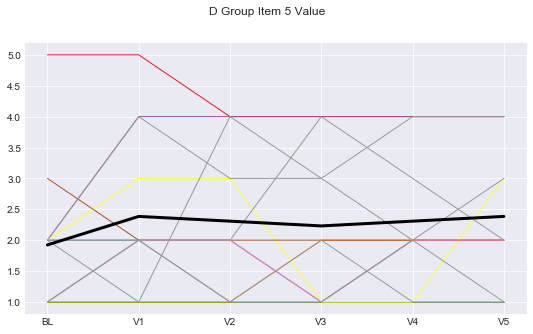

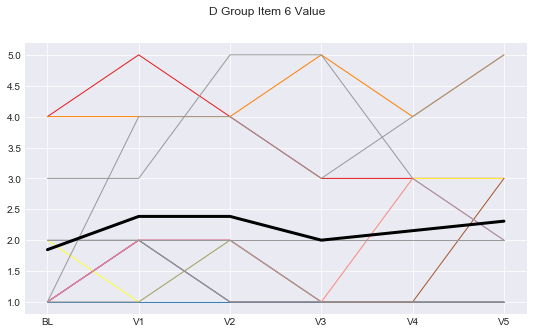

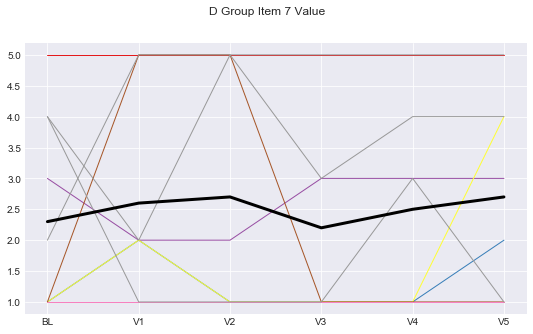

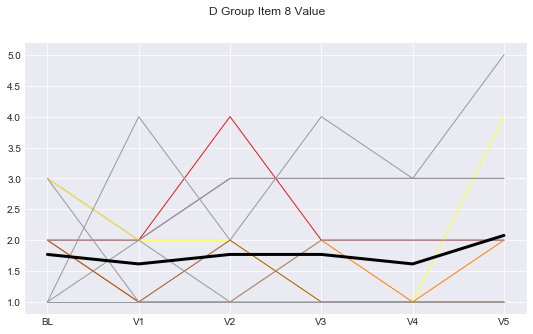

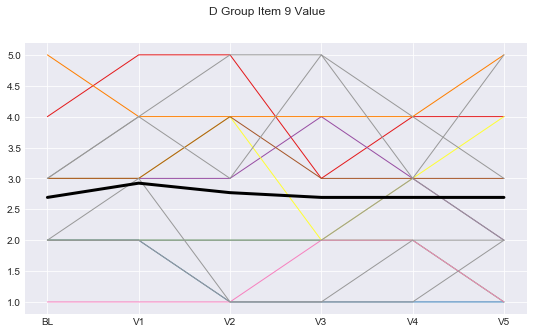

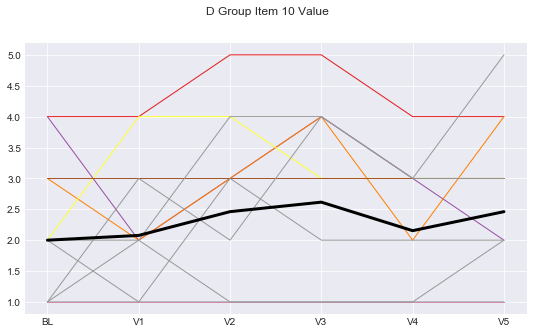

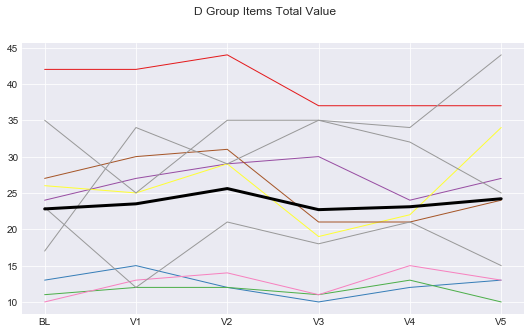

Original Data Plots


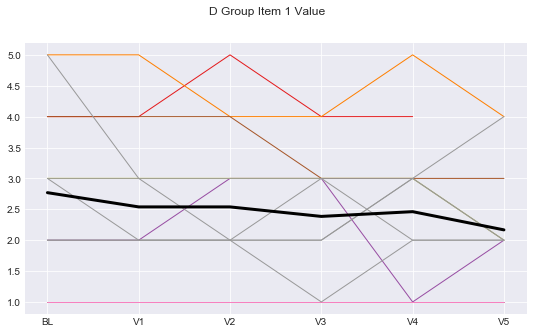

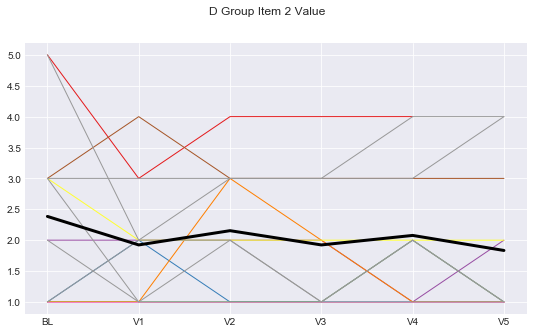

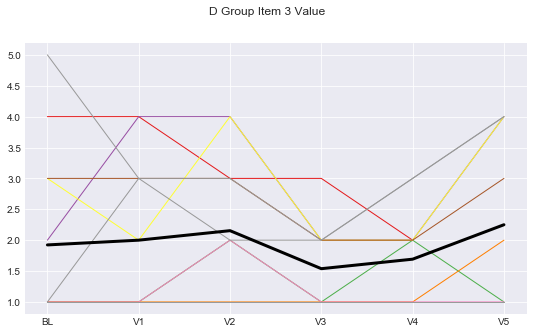

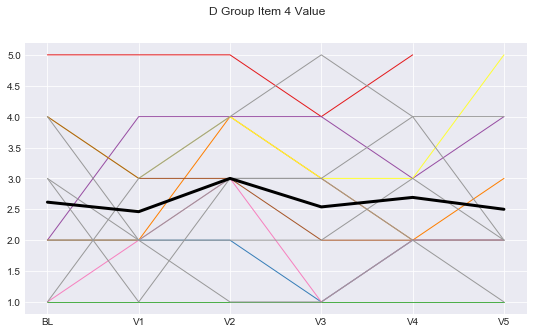

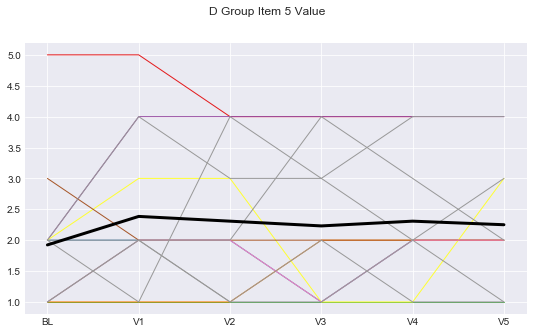

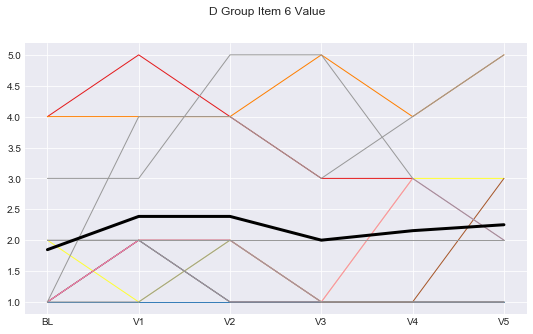

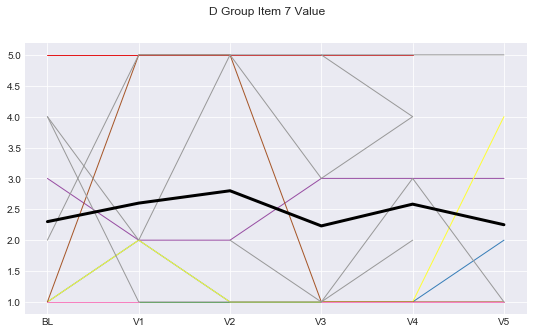

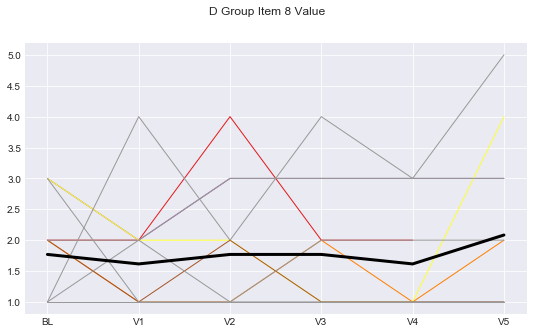

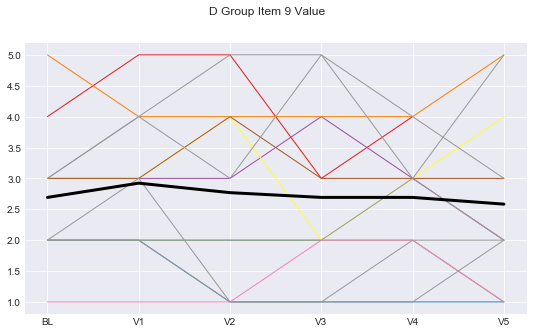

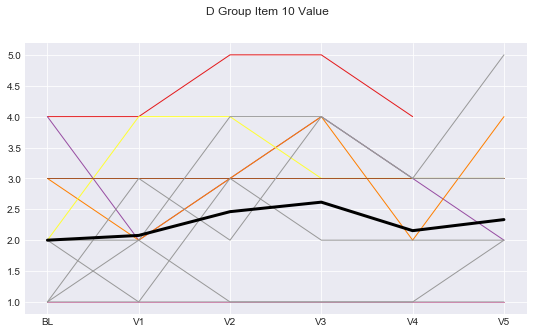

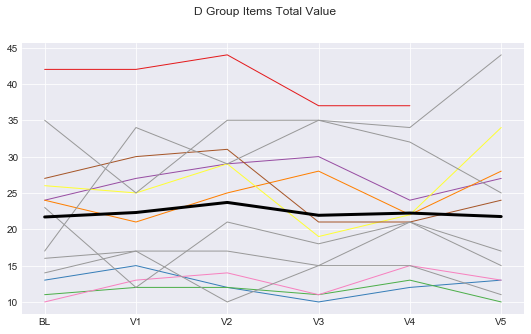

In [29]:
# Need to loop through the different subscores for each S and D
timepoints=['BL', 'V1', 'V2', 'V3', 'V4', 'V5']

# LOCF data
print('LOCF Data Plots')

count=1
for i in range(11):
    if i!=10:
        itemnum=str(count)
    D_item=D_vq_locf[items[i]]
    # Add a row for the mean of all patients at each tp
    D_item=D_item.append(D_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_item.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_item.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=10:
        plt.suptitle('D Group Item '+itemnum+' Value')
    elif i==10:
        plt.suptitle('D Group Items Total Value')
    plt.show()
    count+=1
    
# Original data
print('Original Data Plots')

count=1
for i in range(11):
    if i!=10:
        itemnum=str(count)
    D_item=D_vq_orig[items[i]]
    # Add a row for the mean of all patients at each tp
    D_item=D_item.append(D_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_item.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_item.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=10:
        plt.suptitle('D Group Item '+itemnum+' Value')
    elif i==10:
        plt.suptitle('D Group Items Total Value')
    plt.show()
    count+=1

Comparison Data Plots
S Group Plots


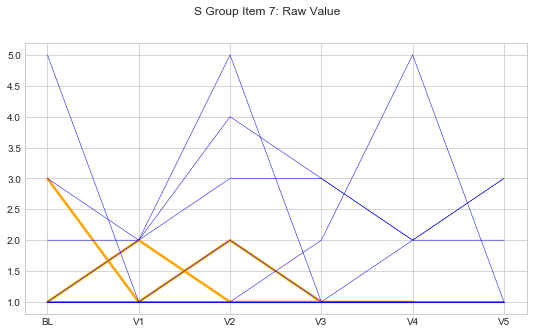

D Group Plots


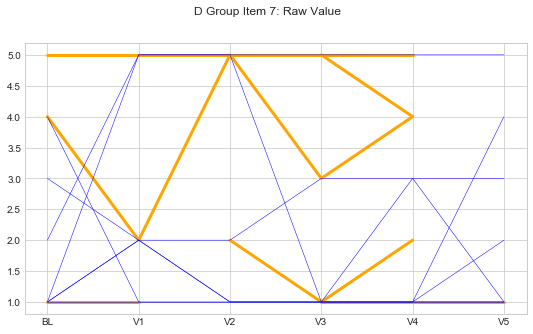

S Group Plots


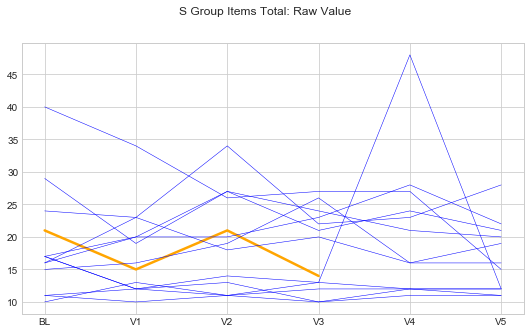

D Group Plots


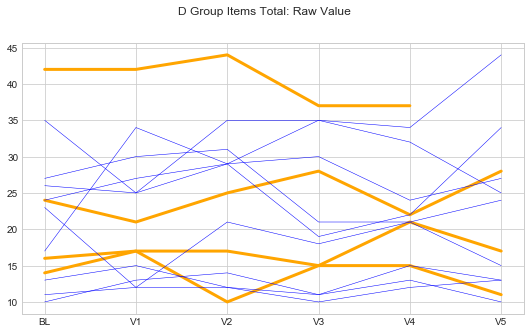

S Group Plots


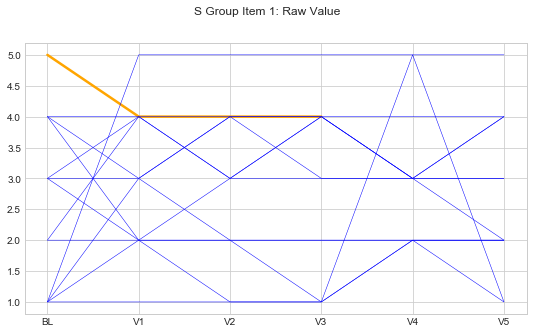

D Group Plots


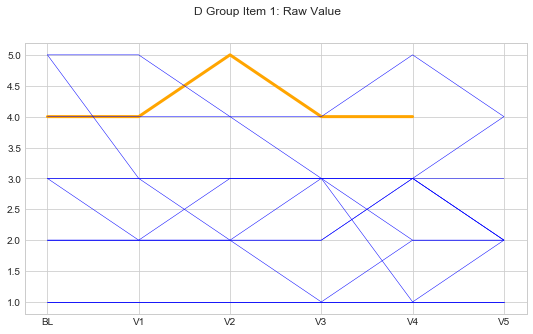

S Group Plots


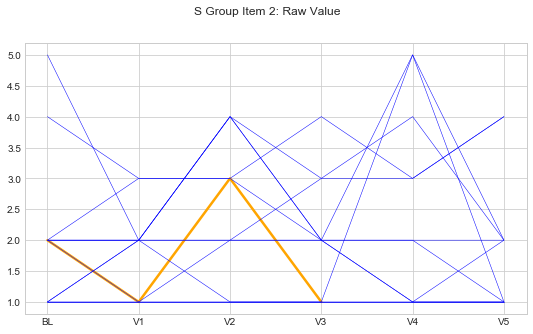

D Group Plots


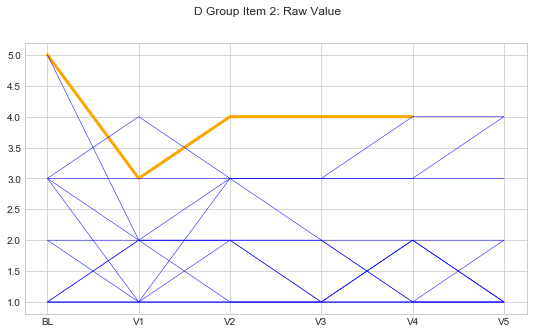

S Group Plots


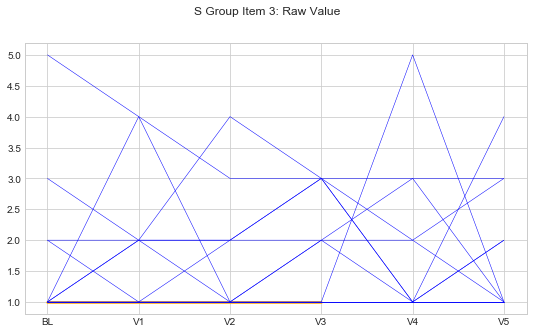

D Group Plots


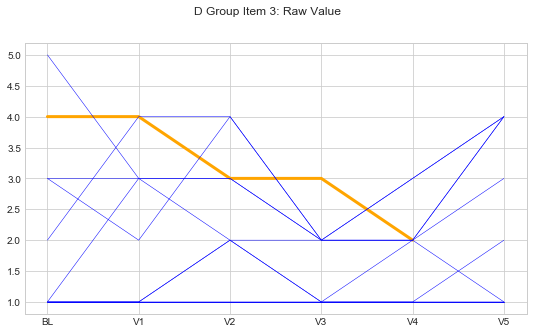

S Group Plots


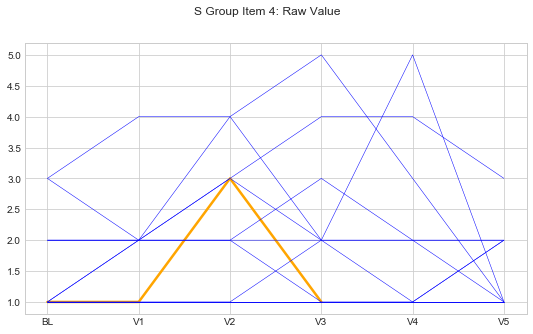

D Group Plots


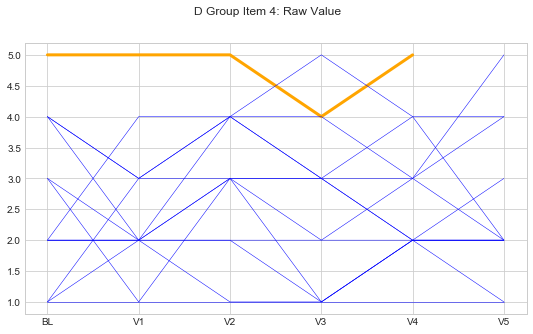

S Group Plots


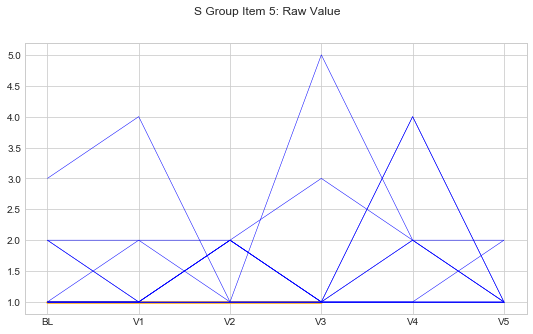

D Group Plots


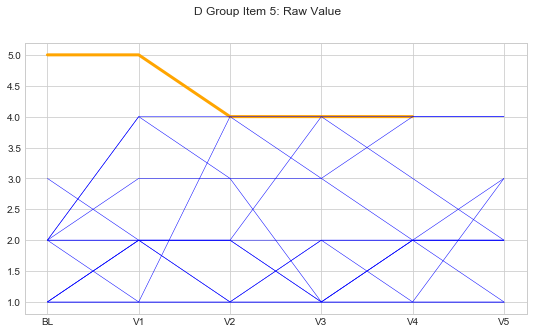

S Group Plots


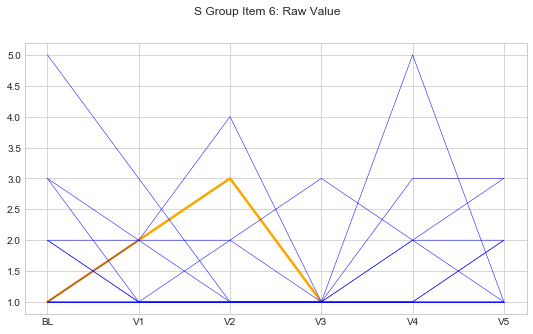

D Group Plots


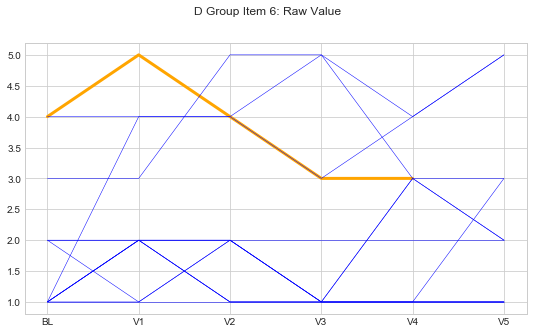

S Group Plots


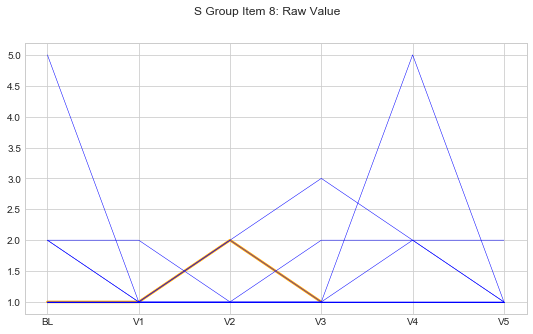

D Group Plots


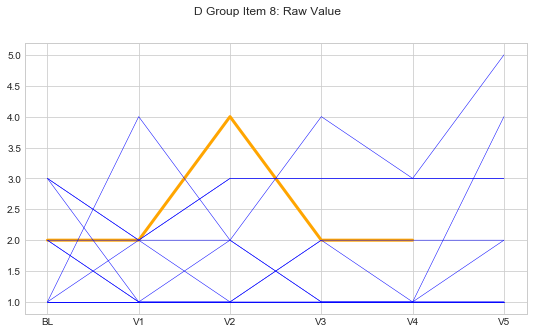

S Group Plots


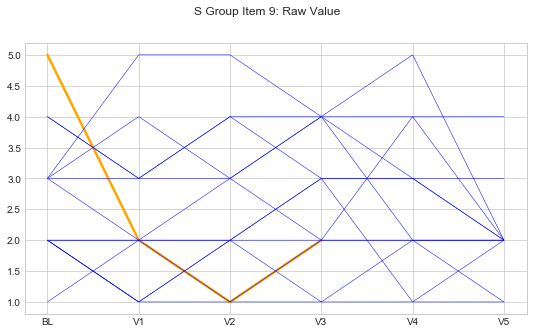

D Group Plots


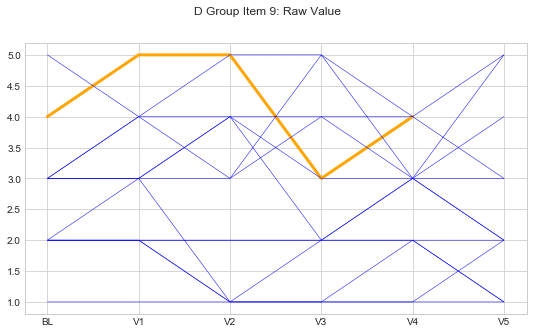

S Group Plots


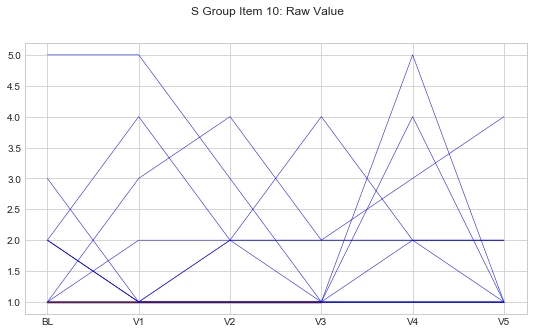

D Group Plots


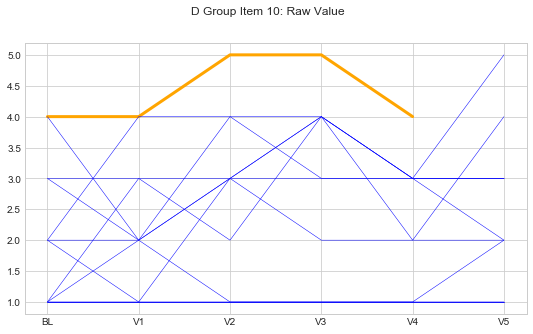

In [31]:
print('Comparison Data Plots')

count=1
for listnum in range(len(miss_group)):
    subgroup=miss_group[listnum]
    subID=miss_ID[listnum]
    plot_item=miss_item[listnum]
    
    miss_S=[]
    miss_D=[]
    for j in range(len(subgroup)):
        if subgroup[j]=='S':
            miss_S.append(subID[j])
        if subgroup[j]=='D':
            miss_D.append(subID[j])
    
    plt.style.use('seaborn-whitegrid')
    palette=plt.get_cmap('Set3')
    
    print('S Group Plots')
    full_S=S_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_S)):
        miss_S_plot=S_vq_orig[items[plot_item]].loc[S_vq_orig['ID']==miss_S[pnum]].iloc[0]
        plt.plot(timepoints, miss_S_plot[1:], marker='', color='#FFA500', linewidth=2.5)
        full_S.remove(miss_S[pnum])
    for pnum in range(len(full_S)):
        full_S_plot=S_vq_orig[items[plot_item]].loc[S_vq_orig['ID']==full_S[pnum]].iloc[0]
        plt.plot(timepoints, full_S_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if plot_item==10:
        plt.suptitle('S Group Items Total: Raw Value')
    else:
        plt.suptitle('S Group Item '+str(plot_item+1)+': Raw Value')
    plt.show()
    
    print('D Group Plots')
    full_D=D_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_D)):
        miss_D_plot=D_vq_orig[items[plot_item]].loc[D_vq_orig['ID']==miss_D[pnum]].iloc[0]
        plt.plot(timepoints, miss_D_plot[1:], marker='', color='#FFA500', linewidth=3)
        full_D.remove(miss_D[pnum])
    for pnum in range(len(full_D)):
        full_D_plot=D_vq_orig[items[plot_item]].loc[D_vq_orig['ID']==full_D[pnum]].iloc[0]
        plt.plot(timepoints, full_D_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if plot_item==10:
        plt.suptitle('D Group Items Total: Raw Value')
    else:
        plt.suptitle('D Group Item '+str(plot_item+1)+': Raw Value')
    plt.show()
    

# Groupwise Pre-Post

Does singing better VRQOL subscores?

Pre-post intervention: Raw value comparisons 
S: BL vs V2 and D: V2 vs V4

LOCF Data Plots


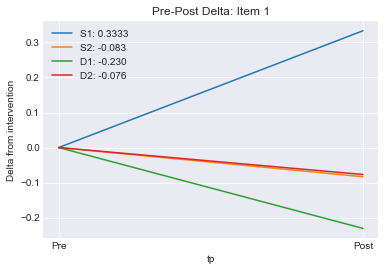

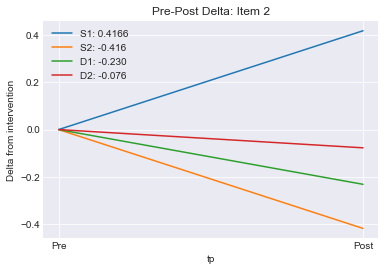

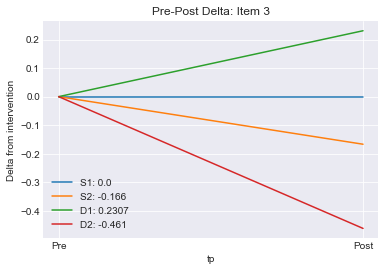

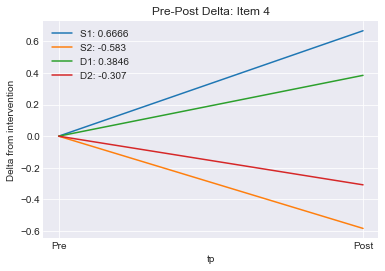

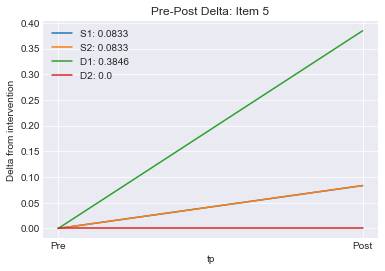

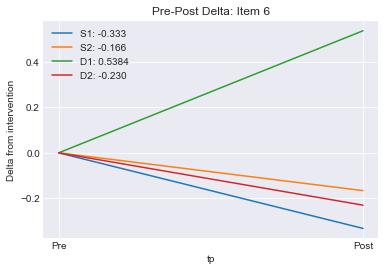

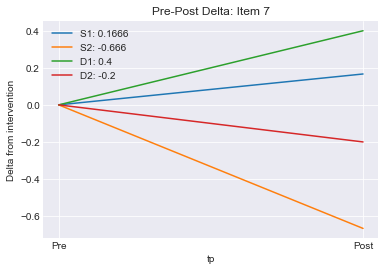

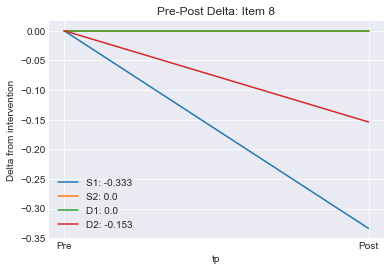

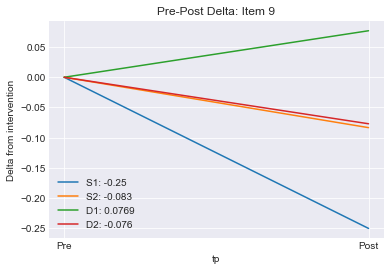

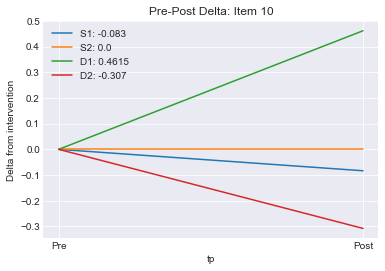

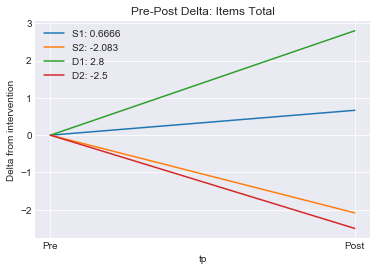

Original Data Plots


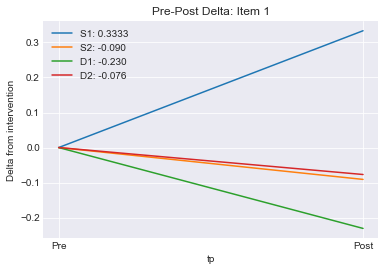

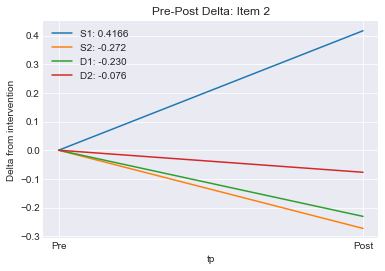

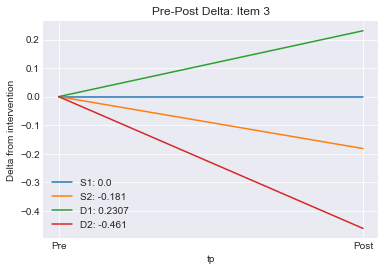

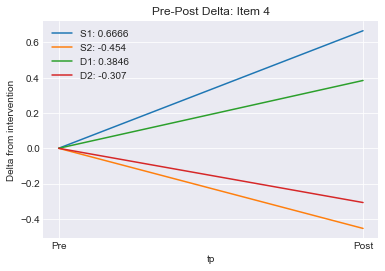

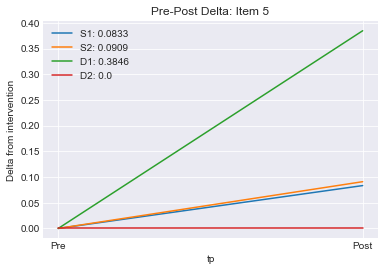

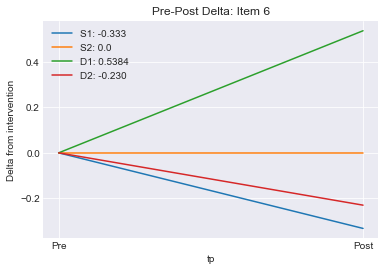

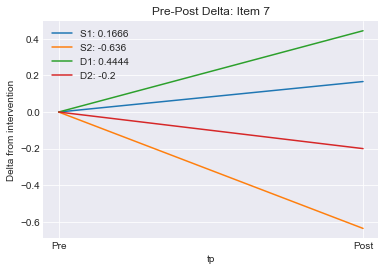

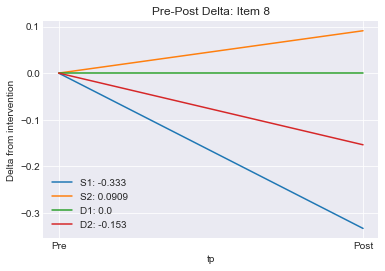

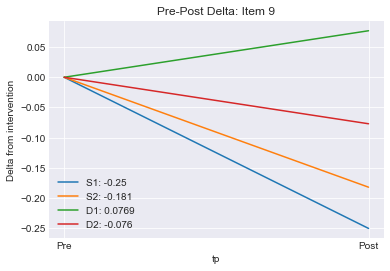

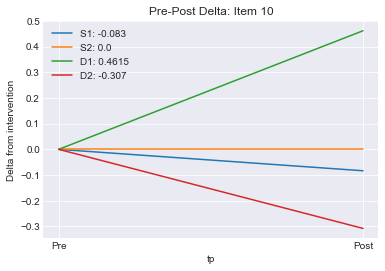

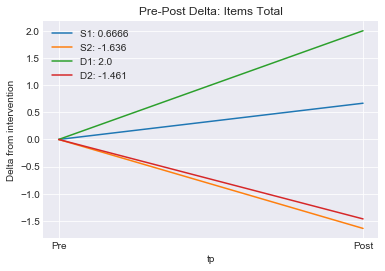

In [59]:
# Plots: want to compare gradients of the 4 groups' DELTAS
# Make lineplots of all 4 groups on one plot for eachof the voice measures

tp=['Post', 'Pre']

# LOCF Data 
print('LOCF Data Plots')
for i in range(11):
    if i!=10:
        scorename='Item '+str(i+1)
    if i==10:
        scorename='Items Total'
    temp_S=S_vq_locf[items[i]].iloc[:, np.r_[1,3,5]].drop([8]) # Drop patient ID 35303
    temp_D=D_vq_locf[items[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()
    
# Original Data 
print('Original Data Plots')
for i in range(11):
    if i!=10:
        scorename='Item '+str(i+1)
    if i==10:
        scorename='Items Total'
    temp_S=S_vq_orig[items[i]].iloc[:, np.r_[1,3,5]].drop([8]) # Drop patient ID 35303
    temp_D=D_vq_orig[items[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()

In [17]:
# Create 4 initial dfs to append to within each loop

# LOCF Data
s1_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
s2_locf=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
d1_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
d2_locf=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_locf, s2_locf, d1_locf, d2_locf]

count=1
for i in range(11):
    if i!=10:
        itemnum=str(i+1)
    elif i==10:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_vq=S_vq_locf[items[i]].iloc[:, 1:4]
    s2_vq=S_vq_locf[items[i]].iloc[:, 4:]
    d1_vq=D_vq_locf[items[i]].iloc[:, 1:4]
    d2_vq=D_vq_locf[items[i]].iloc[:, 4:]
    vqdflist=[s1_vq, s2_vq, d1_vq, d2_vq]

    for j in range(4):
        tempdf=tempdflist[j]
        tempvq=vqdflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempvq.iloc[:, 0], tempvq.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempvq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempvq.iloc[:, 2])

        if j==0:
            s1_locf=pd.concat([s1_locf, tempdf], sort=False)
        elif j==1:
            s2_locf=pd.concat([s2_locf, tempdf], sort=False)
        elif j==2:
            d1_locf=pd.concat([d1_locf, tempdf], sort=False)
        elif j==3:
            d2_locf=pd.concat([d2_locf, tempdf], sort=False)
    count+=1
    
# Original Data
s1_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
s2_orig=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
d1_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
d2_orig=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_orig, s2_orig, d1_orig, d2_orig]

count=1
for i in range(11):
    if i!=10:
        itemnum=str(i+1)
    elif i==10:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_vq=S_vq_orig[items[i]].iloc[:, 1:4]
    s2_vq=S_vq_orig[items[i]].iloc[:, 4:]
    d1_vq=D_vq_orig[items[i]].iloc[:, 1:4]
    d2_vq=D_vq_orig[items[i]].iloc[:, 4:]
    vqdflist=[s1_vq, s2_vq, d1_vq, d2_vq]

    for j in range(4):
        tempdf=tempdflist[j]
        tempvq=vqdflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempvq.iloc[:, 0], tempvq.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempvq.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempvq.iloc[:, 2])

        if j==0:
            s1_orig=pd.concat([s1_orig, tempdf], sort=False)
        elif j==1:
            s2_orig=pd.concat([s2_orig, tempdf], sort=False)
        elif j==2:
            d1_orig=pd.concat([d1_orig, tempdf], sort=False)
        elif j==3:
            d2_orig=pd.concat([d2_orig, tempdf], sort=False)
    count+=1

In [18]:
# Apply Simes-Hoch method to correct FDR: step-up
# Add true/false as a column to see if reject or not
# Investigating: s2 item 9, d2 item 3
sh_s1=smt.multipletests(s1_locf.iloc[:, 1], alpha=0.05, method='sh')
s1_locf['pval']=sh_s1[1]
cols=['Item #', 'pval', 'BL Mean', 'V2 Mean']
s1_locf=s1_locf.loc[:, cols]

sh_s2=smt.multipletests(s2_locf.iloc[:, 1], alpha=0.05, method='sh')
s2_locf['pval']=sh_s2[1]
cols=['Item #', 'pval', 'V2 Mean', 'V4 Mean']
s2_locf=s2_locf.loc[:, cols]

sh_d1=smt.multipletests(d1_locf.iloc[:, 1], alpha=0.05, method='sh')
d1_locf['pval']=sh_d1[1]
cols=['Item #', 'pval', 'BL Mean', 'V2 Mean']
d1_locf=d1_locf.loc[:, cols]

sh_d2=smt.multipletests(d2_locf.iloc[:, 1], alpha=0.05, method='sh')
d2_locf['pval']=sh_d2[1]
cols=['Item #', 'pval', 'V2 Mean', 'V4 Mean']
d2_locf=d2_locf.loc[:, cols]

Orig results

s2, d2: One pval each that is sub 0.05. So, implement Simes-Hoch correction for multiple comparisons

--> After correction, fail to reject H0 for all items. Reporting post-correction.

No change after omission of patient ID 35303

In [20]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\LOCF\VQ_TTest_Groupwise_S1_LOCF.xlsx')
s2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\LOCF\VQ_TTest_Groupwise_S2_LOCF.xlsx')
d1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\LOCF\VQ_TTest_Groupwise_D1_LOCF.xlsx')
d2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\LOCF\VQ_TTest_Groupwise_D2_LOCF.xlsx')

s1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\Original\VQ_TTest_Groupwise_S1_Orig.xlsx')
s2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\Original\VQ_TTest_Groupwise_S2_Orig.xlsx')
d1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\Original\VQ_TTest_Groupwise_D1_Orig.xlsx')
d2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\VRQOL\Original\VQ_TTest_Groupwise_D2_Orig.xlsx')

# Groupwise Delta Significance Testing

Compare deltas of S1 to S2, D1 to D2

In [87]:
# LOCF Data

# Create 4 initial dfs to append to within each loop
# s_locf=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
# d_locf=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
# dflist=[s_locf, d_locf]

# count=1
# # test with mobility first
# for i in range(9):
#     if i!=8:
#         scorename=subscores[i][1][:3]
#     elif i==8:
#         scorename='Summary Index'
#     # Make a list of temp dataframes to iterate thru
#     s_locf_temp=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
#     d_locf_temp=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
#     tempdflist=[s_locf_temp, d_locf_temp]

#     # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
#     s1_delta=S_pdq_locf[subscores[i]].iloc[:,3]-S_pdq_locf[subscores[i]].iloc[:,1]
#     s2_delta=S_pdq_locf[subscores[i]].iloc[:,5]-S_pdq_locf[subscores[i]].iloc[:,3]
#     d1_delta=D_pdq_locf[subscores[i]].iloc[:,3]-D_pdq_locf[subscores[i]].iloc[:,1]
#     d2_delta=D_pdq_locf[subscores[i]].iloc[:,5]-D_pdq_locf[subscores[i]].iloc[:,3]
#     deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

#     for j in range(2):
#         tempdf=tempdflist[j]
#         delta1=deltadflist[j][0]
#         delta2=deltadflist[j][1]
#         tempdf['Subscore']=scorename
#         tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
#         tempdf.iloc[:, 2]=np.mean(delta1)
#         tempdf.iloc[:, 3]=np.mean(delta2)

#         if j==0:
#             s_locf=pd.concat([s_locf, tempdf], sort=False)
#         elif j==1:
#             d_locf=pd.concat([d_locf, tempdf], sort=False)
#     count+=1
    
# Original Data

# Create 4 initial dfs to append to within each loop
s_orig=pd.DataFrame(columns=['Item #', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_orig=pd.DataFrame(columns=['Item #', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_orig, d_orig]

count=1
# test with mobility first
for i in range(11):
    if i!=10:
        itemnum=str(count)
    elif i==10:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s_orig_temp=pd.DataFrame(columns=['Item #', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_orig_temp=pd.DataFrame(columns=['Item #', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_orig_temp, d_orig_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_vq_orig[items[i]].iloc[:,3]-S_vq_orig[items[i]].iloc[:,1]
    s2_delta=S_vq_orig[items[i]].iloc[:,5]-S_vq_orig[items[i]].iloc[:,3]
    d1_delta=D_vq_orig[items[i]].iloc[:,3]-D_vq_orig[items[i]].iloc[:,1]
    d2_delta=D_vq_orig[items[i]].iloc[:,5]-D_vq_orig[items[i]].iloc[:,3]
    s1_delta=s1_delta.drop([8])
    s2_delta=s2_delta.drop([8])

    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_orig=pd.concat([s_orig, tempdf], sort=False)
        elif j==1:
            d_orig=pd.concat([d_orig, tempdf], sort=False)
    count+=1

In [88]:
s_orig

,Item #,pval,S1 Mean Delta,S2 Mean Delta
1,1,0.294390,0.333333,-0.0909091
2,2,0.360691,0.416667,-0.272727
3,3,0.826281,0,-0.181818
4,4,0.012728,0.666667,-0.454545
5,5,1.000000,0.0833333,0.0909091
6,6,0.257796,-0.333333,0
7,7,0.290260,0.166667,-0.636364
8,8,0.192127,-0.333333,0.0909091
9,9,0.431579,-0.25,-0.181818
10,10,0.862788,-0.0833333,0


In [89]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
# s_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\PDQ39\LOCF\PDQ39_TTest_SDelta.xlsx')
# d_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\PDQ39\LOCF\PDQ39_TTest_DDelta.xlsx')
s_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\VRQOL\Original\VQ_TTest_SDelta.xlsx')
d_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\VRQOL\Original\VQ_TTest_DDelta.xlsx')